In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pymc as pm

In [ ]:
def load_data(table="ice_cores"):
    """'table' should either be 'ice_cores' or 'stalagmites'."""
    
    if table == "ice_cores":
        df = pd.read_excel("data/d18O NGRIP 21.04.24.xlsx", skiprows=9, 
                           usecols=[2,3], dtype=float)
    elif table == "stalagmites":
        df = pd.read_excel("data/Borneo Stalagmite 02.04.25.xlsx", 
                           skiprows=9, usecols=[1,2], dtype=float)
    
    # set first year to 0 and choose years less than "N_YEARS"
    df.iloc[:,0] -= min(df.iloc[:,0])
    df = df[df.iloc[:,0] <= N_YEARS]
    
    # center data
    df.iloc[:,1] -= np.mean(df.iloc[:,1])

    return df.iloc[:,0].values, df.iloc[:,1].values

def extract_harmonics(t, y):
    residuals = y.copy()
    harmonics = []
    params = {
        "P": [], "dP": [], "A": [], "dA": [], "Phi": [], "dPhi": []
    }

    for i in range(MAX_HARMONICS):
        # feedback
        print_feedback(i)

        # compute periodogram of residuals
        P_guess = find_dominant_period(t, residuals)

        # fit harmonic
        fit_params, trace = fit_harmonic(t, residuals, P_guess)

        # build the harmonic with inferred params and subtract from residuals
        harmonic = build_model(t, fit_params[2], fit_params[0], fit_params[4])
        residuals -= harmonic

        # save current harmonic model and its params values
        harmonics.append(harmonic)
        for i,param_name in enumerate(["P", "A", "Phi"]):
            params[param_name].append(fit_params[2*i])
            params["d" + param_name].append(fit_params[2*i + 1])

    final_model = np.sum(harmonics, axis=0)
    params = pd.DataFrame(params)

    return final_model, params, residuals

def print_feedback(current_iteration):
    print(60 * "-")
    text = f" Iteration number {current_iteration+1} of {MAX_HARMONICS} "
    left_text = " " * ((60 - len(text))//2)
    right_text = " " * (60 - len(left_text))
    print(f"{left_text}{text}{right_text}")
    print(60 * "-")

def find_dominant_period(t, y):
    # uniform t and y for fourier transform
    dt  = np.median(np.diff(t))
    t_u = np.arange(t[0], t[-1] + dt, dt)
    y_u = np.interp(t_u, t, y)

    # get frequencies and find peaks
    frequencies = np.fft.rfftfreq(len(y_u), dt)
    ck = np.fft.rfft(y_u)
    power = np.abs(ck) ** 2

    # find peaks above noise floor
    min_height = np.max(power) / NOISE_RATIO_THRESHOLD
    peaks, _ = find_peaks(power, height=min_height)
    #peaks, _ = find_peaks(power)
    
    if len(peaks) > 0:
        dominant_peak_ix = peaks[np.argmax(power[peaks])]
    else:
        dominant_peak_ix = 0

    # convert to period
    dominant_period = 1 / frequencies[dominant_peak_ix]

    # plot periodogram
    plt.figure(figsize=(12,4))

    periods = 1 / frequencies
    peak_periods = periods[peaks]
    print(peak_periods)
    
    peak_powers = power[peaks]

    plt.loglog(periods, power, 'b-', alpha=0.7, linewidth=0.8)
    plt.axhline(min_height, color='red', linestyle='--', label='Threshold')
    plt.scatter(peak_periods, peak_powers, color='red', s=50, zorder=5, 
                label=f'{len(peaks)} peaks found')
    
    plt.xlabel('Period')
    plt.ylabel('Power')
    plt.title("Periodogram")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return dominant_period

def fit_harmonic(t, y, period_guess):
    y_std = y.std()

    with pm.Model() as harmonic:
        # priors
        A = pm.HalfNormal("A", sigma=y_std)
        P = pm.Normal("P", mu=period_guess, sigma=0.1*period_guess)
        phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sig = pm.HalfNormal("sigma", sigma=y_std)
        rho = pm.Uniform("rho", -1, 1)
        noise = pm.AR("noise", rho, sigma=pm.HalfNormal("noise_sigma"), 
                     init_dist=pm.Normal.dist(0, 1), shape=len(t))

        mu = A * pm.math.cos(2*np.pi * t / P + phi)
        pm.Normal("y_obs", mu=mu + noise, sigma=sig, observed=y)

        trace = pm.sample(N_SAMPLES, tune = N_TUNE, chains = N_CHAINS,
                          cores = min(4, N_CHAINS),
                          target_accept = 0.95,
                          return_inferencedata = True)
    params = []
    for param_name in ["P", "A", "phi"]:
        param_post = trace.posterior[param_name]
        
        # mean and std of current param
        params.append( param_post.mean().item() )
        params.append( param_post.std().item() )

    return params, trace

def build_model(t, A, P, phi):
    return A * np.cos(2 * np.pi * t / P + phi)

def show_results(t, y, model, residuals):
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    
    # plot proposed total fit
    axes[0].plot(t, y, 'k-', alpha=0.5, linewidth=0.5, label='Original Data')
    axes[0].plot(t, model, 'r-', linewidth=2, 
                label='Bayesian Fit')
    axes[0].set_title('Bayesian Harmonic Fit')
    axes[0].set_ylabel('Signal')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # plot proposed residuals
    axes[1].plot(t, residuals, 'b-', linewidth=0.8, alpha=0.7)
    res_std = np.std(residuals)
    axes[1].axhline(res_std, color='red', linestyle='--', alpha=0.7, 
                   label=f'±1σ = ±{res_std:.4f}')
    axes[1].axhline(-res_std, color='red', linestyle='--', alpha=0.7)
    axes[1].set_title('Residuals')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Residual')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# general settings
N_YEARS = 10000
MAX_HARMONICS = 5
NOISE_RATIO_THRESHOLD = 10
SAVE_PARAMS = False

# pymc settings
N_SAMPLES = 1000
N_TUNE = 1000
N_CHAINS = 4

In [ ]:
t, y = load_data("stalagmites")
model, params, residuals = extract_harmonics(t, y)

In [ ]:
show_results(t, y, model, residuals)

In [ ]:
params

Found candidate periods: []


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


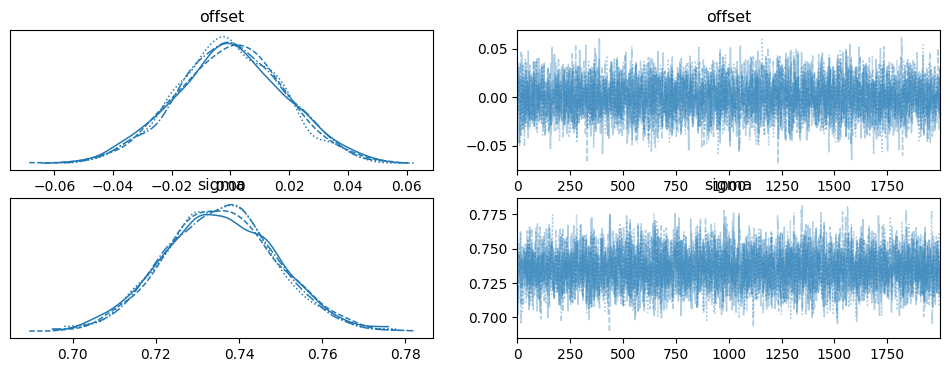

ValueError: x and y must have same first dimension, but have shapes (1583,) and (1,)

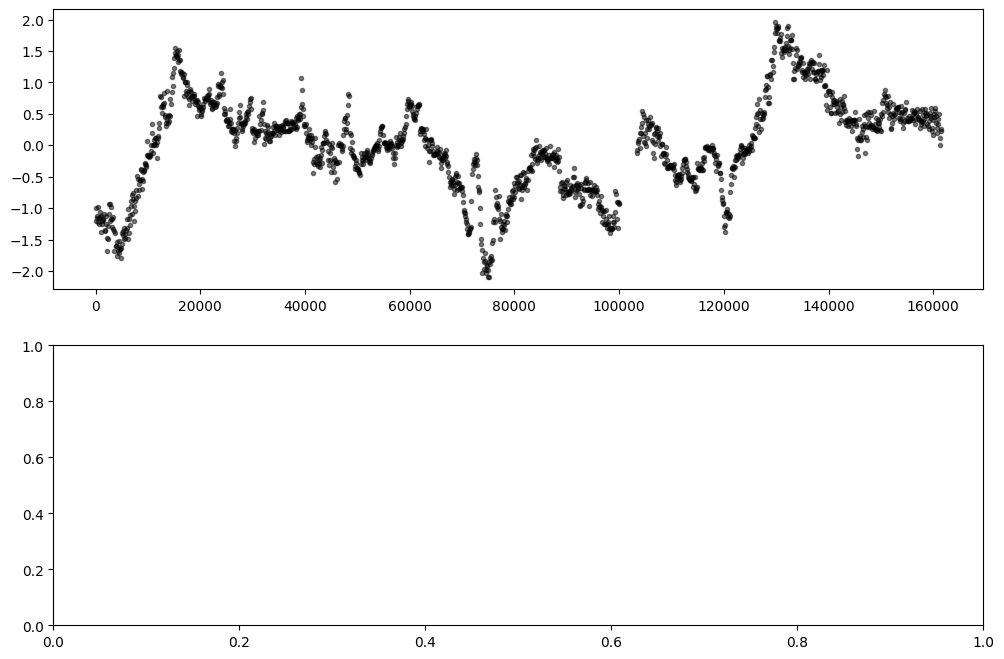

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, csd
import pymc as pm
import arviz as az

# Updated settings
CONFIG = {
    "max_harmonics": 5,
    "noise_threshold": 0.2,
    "n_samples": 2000,
    "n_tune": 1000,
    "n_chains": 4,
    "target_accept": 0.95,
    "n_years": 10000
}

def spectral_analysis(t, y, n_perseg=256):
    """Spectral analysis using Welch's method"""
    dt = np.median(np.diff(t))
    t_uniform = np.arange(t.min(), t.max(), dt)
    y_uniform = np.interp(t_uniform, t, y)
    
    # Compute power spectral density
    freqs, psd = welch(y_uniform, fs=1/dt, nperseg=n_perseg)
    periods = 1 / freqs[freqs > 0]
    psd = psd[freqs > 0]
    
    # Find significant peaks
    peaks, _ = find_peaks(psd, height=CONFIG["noise_threshold"]*psd.max())
    return periods[peaks], psd[peaks]

def build_harmonic_model(t, y, candidate_periods):
    """Build Bayesian model with all harmonics simultaneously"""
    with pm.Model() as model:
        # Base parameters
        sigma = pm.HalfNormal("sigma", sigma=y.std())
        offset = pm.Normal("offset", mu=0, sigma=y.std())
        
        # Harmonic components
        harmonics = []
        for i, P0 in enumerate(candidate_periods):
            # Wide period prior ±20%
            P = pm.Normal(f"P_{i}", mu=P0, sigma=0.2*P0)
            
            # Allow negative amplitudes
            A = pm.Normal(f"A_{i}", mu=0, sigma=y.std())
            
            # Circular phase handling
            phi = pm.VonMises(f"phi_{i}", mu=0, kappa=1)
            
            harmonics.append(A * pm.math.cos(2*np.pi*t/P + phi))
        
        # Combined signal
        mu = offset + pm.math.sum(harmonics)
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    return model

def main():
    t, y = load_data("stalagmites")
    
    # Step 1: Spectral analysis to find candidate periods
    candidate_periods, peak_powers = spectral_analysis(t, y)
    print(f"Found candidate periods: {candidate_periods}")
    
    # Limit to top N periods
    n_harmonics = min(CONFIG["max_harmonics"], len(candidate_periods))
    candidate_periods = candidate_periods[:n_harmonics]
    
    # Step 2: Build and fit model
    model = build_harmonic_model(t, y, candidate_periods)
    with model:
        trace = pm.sample(
            CONFIG["n_samples"],
            tune=CONFIG["n_tune"],
            chains=CONFIG["n_chains"],
            target_accept=CONFIG["target_accept"]
        )
    
    # Step 3: Analysis and visualization
    az.plot_trace(trace)
    plt.show()
    
    # Reconstruct signal
    posterior = trace.posterior
    reconstruction = posterior["offset"].mean().item()
    for i in range(n_harmonics):
        A = posterior[f"A_{i}"].mean().item()
        P = posterior[f"P_{i}"].mean().item()
        phi = posterior[f"phi_{i}"].mean().item()
        reconstruction += A * np.cos(2*np.pi*t/P + phi)
    
    residuals = y - reconstruction
    
    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    ax[0].plot(t, y, 'k.', alpha=0.5, label="Data")
    ax[0].plot(t, reconstruction, 'r-', label="Reconstruction")
    ax[0].set_title(f"Reconstruction with {n_harmonics} harmonics")
    ax[0].legend()
    
    ax[1].plot(t, residuals, 'b-')
    ax[1].axhline(0, color='k', linestyle='--')
    ax[1].set_title(f"Residuals (RMSE: {np.sqrt(np.mean(residuals**2)):.4f})")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_0, P_0, phi_0, A_1, P_1, phi_1, A_2, P_2, phi_2, A_3, P_3, phi_3, A_4, P_4, phi_4, A_5, P_5, phi_5, A_6, P_6, phi_6, A_7, P_7, phi_7, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 563 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler..

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_0, P_0, phi_0, A_1, P_1, phi_1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_0, P_0, phi_0, A_1, P_1, phi_1, A_2, P_2, phi_

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_0, P_0, phi_0, A_1, P_1, phi_1, A_2, P_2, phi_2, A_3, P_3, phi_3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 133 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_0, P_0, phi_0, A_1, P_1, phi_1, A_2, P_2, phi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 166 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_0, P_0, phi_0, A_1, P_1, phi_1, A_2, P_2, p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 190 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_0, P_0, phi_0, A_1, P_1, phi_1, A_2, P_2, p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 361 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_0, P_0, phi_0, A_1, P_1, phi_1, A_2, P_2, phi_2, A_3, P_3, phi_3, A_4, P_4, phi_4, A_5, P_5, phi_5, A_6, P_6, phi_6, A_7, P_7, p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 546 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of t

Selected 8 harmonics by WAIC.


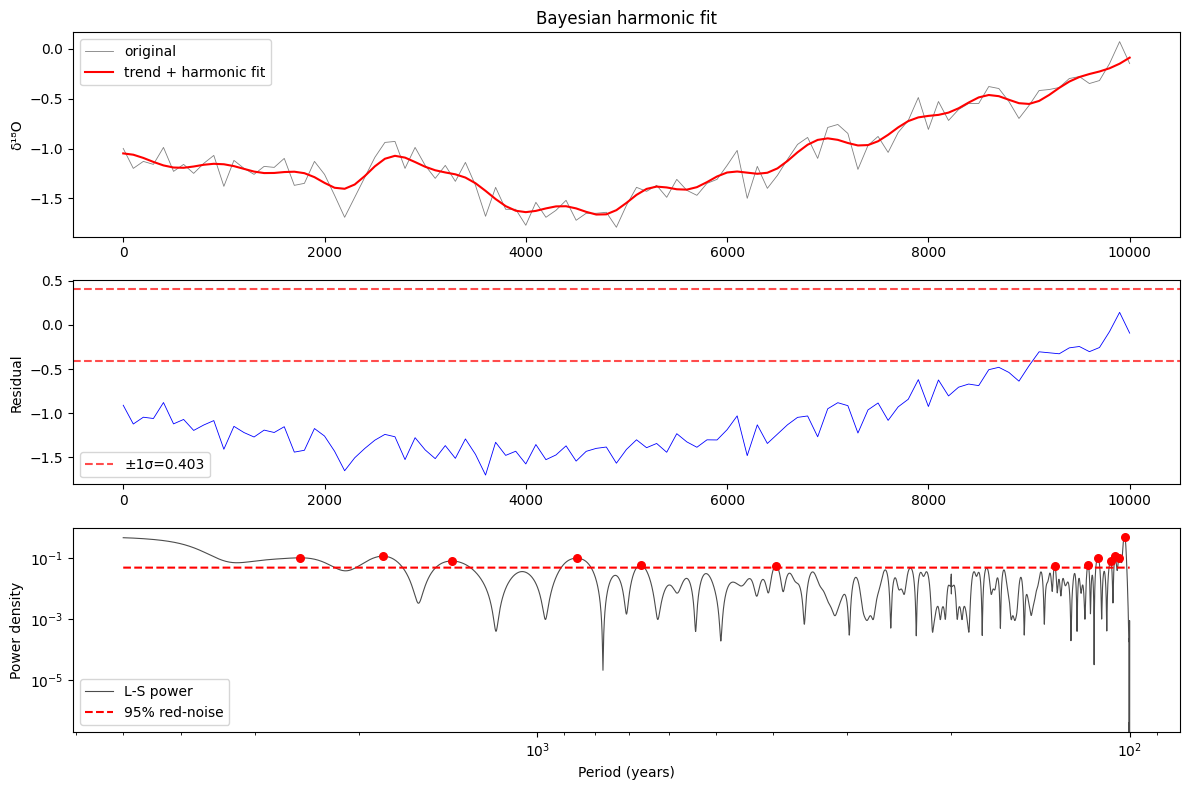

           mean       sd    hdi_3%   hdi_97%
P_0     101.287    7.785    87.933   117.955
P_1     102.622    6.269    94.644   118.160
P_2    1865.844  146.782  1588.618  2211.311
P_3     100.594    5.332    89.154   107.919
P_4    2511.821  195.527  2166.513  2956.327
P_5     107.440    8.779    92.586   122.206
P_6     855.523   38.008   789.479   931.998
P_7     105.155    7.550    91.398   117.976
A_0       0.072    0.045     0.000     0.147
phi_0     3.113    1.710     0.179     5.936
A_1       0.075    0.045     0.000     0.151
phi_1     3.173    1.657     0.438     6.251
A_2       0.056    0.028     0.001     0.096
phi_2     2.566    1.136     0.063     4.476
A_3       0.080    0.048     0.000     0.157
phi_3     3.257    1.538     0.665     6.281
A_4       0.072    0.031     0.008     0.120
phi_4     4.349    1.322     0.990     6.276
A_5       0.061    0.043     0.000     0.140
phi_5     2.979    1.743     0.093     5.836
A_6       0.056    0.025     0.006     0.095
phi_6     

In [15]:
# -*- coding: utf-8 -*-
"""
Bayesian harmonic analysis for irregularly‑sampled palaeoclimate time‑series
----------------------------------------------------------------------------
Implements the upgrade path discussed:
1.  load & centre data, optional Savitzky–Golay smoothing
2.  detrend with a low‑order polynomial
3.  Lomb–Scargle periodogram + AR(1) red‑noise significance
4.  pick significant peaks and build a *joint* PyMC model with those periods
5.  model selection via WAIC
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from astropy.timeseries import LombScargle
import pymc as pm
import arviz as az
import warnings
import sys

# General settings
N_YEARS = 10000
MAX_HARMONICS = 8
SIG_LEVEL = 0.95

# -------------------------------------------------------------------------
# 1. LOAD AND PRE-PROCESS DATA
# -------------------------------------------------------------------------
def load_data(table="ice_cores"):
    if table == "ice_cores":
        df = pd.read_excel("data/d18O NGRIP 21.04.24.xlsx", skiprows=9, usecols=[2, 3], dtype=float)
    elif table == "stalagmites":
        df = pd.read_excel("data/Borneo Stalagmite 02.04.25.xlsx", skiprows=9, usecols=[1, 2], dtype=float)
    else:
        raise ValueError("table must be either 'ice_cores' or 'stalagmites'")

    df.iloc[:, 0] -= df.iloc[:, 0].min()
    t = df.iloc[:, 0].values
    y = df.iloc[:, 1].values
    y -= y.mean()
    return t, y

# -------------------------------------------------------------------------
# 2. DETRENDING
# -------------------------------------------------------------------------
def detrend_polynomial(t, y, degree=2):
    coeffs = np.polyfit(t, y, degree)
    trend = np.polyval(coeffs, t)
    return y - trend, trend

# -------------------------------------------------------------------------
# 3. SPECTRUM
# -------------------------------------------------------------------------
def lomb_scargle_periodogram(t, y, minimum_period=100, maximum_period=None, n_samples=10000):
    dt = np.median(np.diff(t))
    duration = t.max() - t.min()
    if maximum_period is None:
        maximum_period = 0.5 * duration
    f_min = 1.0 / maximum_period
    f_max = 1.0 / minimum_period
    if f_max <= f_min:
        raise ValueError(f"Invalid frequency range: f_min={f_min:.5g}, f_max={f_max:.5g}")
    freqs = np.linspace(f_min, f_max, n_samples)
    ls = LombScargle(t, y)
    power = ls.power(freqs, normalization="psd")
    return freqs, power

# -------------------------------------------------------------------------
# 4. PEAK DETECTION & RED NOISE
# -------------------------------------------------------------------------
def significant_peaks(freqs, power, ratio_threshold=10):
    threshold = np.max(power) / ratio_threshold
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(power, height=threshold)
    return peaks, np.full_like(power, threshold)

# -------------------------------------------------------------------------
# 5. PYMC MODEL
# -------------------------------------------------------------------------
def build_pymc_harmonic_model(t, y, period_guesses):
    with pm.Model() as model:
        mu = 0
        for i, P0 in enumerate(period_guesses):
            A = pm.HalfNormal(f"A_{i}", sigma=np.std(y))
            P = pm.Normal(f"P_{i}", mu=P0, sigma=0.1 * P0)
            phi = pm.Uniform(f"phi_{i}", lower=0, upper=2 * np.pi)
            mu += A * pm.math.cos(2 * np.pi * t / P + phi)
        sigma = pm.HalfNormal("sigma", sigma=np.std(y))
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    return model

def sample_model(model):
    with model:
        return pm.sample(
            1000,
            tune=1000,
            chains=4,
            target_accept=0.95,
            return_inferencedata=True,
            compute_convergence_checks=True,
            idata_kwargs={"log_likelihood": True},  # <-- ADD THIS LINE
        )

def compute_posterior_mean(t, idata, k):
    n_time = len(t)
    t_arr = np.array(t)

    # Broadcastable time: shape (1, 1, N)
    t_broadcast = t_arr.reshape(1, 1, n_time)

    mu = 0
    for i in range(k):
        A = idata.posterior[f"A_{i}"].values  # shape (chains, draws)
        P = idata.posterior[f"P_{i}"].values
        phi = idata.posterior[f"phi_{i}"].values

        # Reshape to (chains, draws, 1) for broadcasting
        A = A[:, :, None]
        P = P[:, :, None]
        phi = phi[:, :, None]

        mu += A * np.cos(2 * np.pi * t_broadcast / P + phi)

    # Now average over chains and draws
    return mu.mean(axis=(0, 1))  # shape: (n_time,)

# -------------------------------------------------------------------------
# MAIN ANALYSIS
# -------------------------------------------------------------------------
def run_analysis(table="ice_cores", k_max=MAX_HARMONICS):
    t, y_raw = load_data(table)
    
    # limit to first n years
    mask = t <= N_YEARS
    t = t[mask]
    y_raw = y_raw[mask]

    # detrend
    y, trend = detrend_polynomial(t, y_raw)
    freqs, power = lomb_scargle_periodogram(t, y)
    peaks, threshold = significant_peaks(freqs, power)
    top = np.argsort(power[peaks])[::-1][:k_max]
    peak_freqs = freqs[peaks][top]
    period_guesses = 1.0 / peak_freqs

    model = build_pymc_harmonic_model(t, y, period_guesses)
    idata = sample_model(model)

    waic_per_k = []
    for k in range(1, len(period_guesses) + 1):
        sub_model = build_pymc_harmonic_model(t, y, period_guesses[:k])
        sub_idata = sample_model(sub_model)
        waic_result = az.waic(sub_idata)
        waic_value = -2 * waic_result.elpd_waic
        waic_per_k.append(waic_value)

        if k > 1 and waic_per_k[-1] > waic_per_k[-2]:
            best_k = k - 1
            idata = sub_idata_prev
            period_guesses = period_guesses[:best_k]
            break
        sub_idata_prev = sub_idata
    else:
        best_k = len(period_guesses)

    print(f"Selected {best_k} harmonics by WAIC.")
    plot_results(t, y_raw, trend, period_guesses, idata, freqs, power, threshold, peaks)
    return idata

# -------------------------------------------------------------------------
# PLOTTING
# -------------------------------------------------------------------------
def plot_results(t, y_raw, trend, periods, idata, freqs, power, threshold, peaks):
    posterior = idata.posterior
    mu = compute_posterior_mean(t, idata, len(periods))
    residuals = y_raw - mu

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=False)
    axes[0].plot(t, y_raw, "k", lw=0.6, alpha=0.5, label="original")
    axes[0].plot(t, trend + mu, "r", lw=1.5, label="trend + harmonic fit")
    axes[0].set_ylabel("δ¹⁸O")
    axes[0].legend()
    axes[0].set_title("Bayesian harmonic fit")

    axes[1].plot(t, residuals, "b", lw=0.6)
    std = residuals.std()
    axes[1].axhline(std, ls="--", color="red", alpha=0.7)
    axes[1].axhline(-std, ls="--", color="red", alpha=0.7, label=f"±1σ={std:.3f}")
    axes[1].set_ylabel("Residual")
    axes[1].legend()

    periods_plot = 1.0 / freqs
    axes[2].loglog(periods_plot, power, "k", lw=0.8, alpha=0.7, label="L‑S power")
    axes[2].loglog(periods_plot, threshold, "--", color="red", label=f"{SIG_LEVEL*100:.0f}% red‑noise")
    axes[2].scatter(1.0 / freqs[peaks], power[peaks], s=30, color="red", zorder=5)
    axes[2].set_xlabel("Period (years)")
    axes[2].set_ylabel("Power density")
    axes[2].legend(loc="lower left")
    axes[2].invert_xaxis()

    plt.tight_layout()
    plt.show()

    summary = az.summary(idata, var_names=[v for v in idata.posterior if v.startswith("P_") or v.startswith("A_") or v.startswith("phi_")])
    print(summary[["mean", "sd", "hdi_3%", "hdi_97%"]])

# -------------------------------------------------------------------------
# ENTRY POINT
# -------------------------------------------------------------------------
if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description="Bayesian harmonic analysis for palaeoclimate series.")
    parser.add_argument("--table", choices=["ice_cores", "stalagmites"], default="stalagmites", help="Which dataset to analyse.")
    parser.add_argument("--max", type=int, default=MAX_HARMONICS, help="Maximum candidate harmonics to test.")
    args, _ = parser.parse_known_args()
    run_analysis(args.table, k_max=args.max)
